# Chain transfos

Objective:

1. create a transfo from 2 consecutive transfos on a single column
2. create a transfo from 2 parallel transfos on two distinct columns

In [90]:
%load_ext autoreload
%autoreload 2

# Base for the types
import os
import sys
import numpy as np

# Elementary mathematical functions
from skl2onnx.algebra import onnx_ops

# Onnx back function
import onnx
from onnx import helper, ModelProto, AttributeProto, TensorProto, GraphProto
import onnxruntime as rt

# Plot graph
import pydot
from IPython.display import Image
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# Viz functions

def viz_model(onnx_file, verbose=False):
    # Load
    onnx_model = onnx.load(onnx_file)
    model = ModelProto()
    with open(onnx_file, 'rb') as fid:
        content = fid.read()
        model.ParseFromString(content)

    # Make pydot object
    pydot_graph = GetPydotGraph(
        model.graph, name=model.graph.name, rankdir="TB",
        node_producer=GetOpNodeProducer("docstring"))
    graph_file = f"{onnx_file.split('.')[0]}_graph.dot"
    graph_img = f"{onnx_file.split('.')[0]}_graph.png"
    pydot_graph.write(graph_file)
    # Write image
    (graph,) = pydot.graph_from_dot_file(graph_file)
    graph.write_png(graph_img)

    # View transformation
    # # JSON-like
    if verbose:
        print(onnx_model.__str__())
    # # Image
    #Image(graph_img)
    return graph_img

In [113]:
# Make simple onnx model
len_sample = int(1e2)
X = helper.make_tensor_value_info('X', TensorProto.FLOAT, [1, 1])
Y = helper.make_tensor_value_info('Y', TensorProto.FLOAT, [1, 1])
Z = helper.make_tensor_value_info('Z', TensorProto.FLOAT, [1, 1])


np.arange(1 * len_sample).reshape((1, len_sample)).astype(np.float32)

def make_onnx_model(
    onnx_params={
        "name": "absolute_value.onnx",
        "func": onnx_ops.OnnxAbs,
    },
    X=X
):
    # 1. Input shape
    # from doc: np.arrays are good enough to define the input shape

    # 2. Transformation
    node = onnx_params["func"]('X')
    model = node.to_onnx({'X': X})

    # 3. Check if model is OK
    onnx.checker.check_model(abs_model)

    # 4. Save transfo
    onnx_file = onnx_params["name"]
    with open(onnx_file, "wb") as f:
        f.write(model.SerializeToString())
    return viz_model(onnx_file)

# Build models

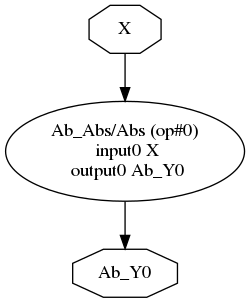

In [93]:
graph_img = make_onnx_model(onnx_params={
    "name": "absolute_value.onnx",
    "func": onnx_ops.OnnxAbs,
})
Image(graph_img)

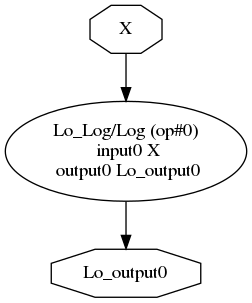

In [94]:
graph_img = make_onnx_model(onnx_params={
    "name": "log.onnx",
    "func": onnx_ops.OnnxLog,
})
Image(graph_img)

# Chain model

In [95]:
models = []

for onnx_file in ["absolute_value.onnx", "log.onnx"]:
    onnx_model = onnx.load(onnx_file)
    model = ModelProto()
    with open(onnx_file, 'rb') as fid:
        content = fid.read()
        model.ParseFromString(content)
    models.append({
        "file": onnx_file,
        "model": model,
    })

In [96]:
m_0 = models[0]["model"]

## Test 1

In [111]:
node_abs = helper.make_node(
    'Abs', # node name
    ['X'], # inputs
    ['Y'], # outputs
)

node_log = helper.make_node(
    'Log', # node name
    ['X'], # inputs
    ['Y'], # outputs
)

graph_def = helper.make_graph(
    [node_abs, node_log],
    'abs_log',
    [X],
    [Y],
)

two_node_model = helper.make_model(graph_def, producer_name='abs-log-ops')

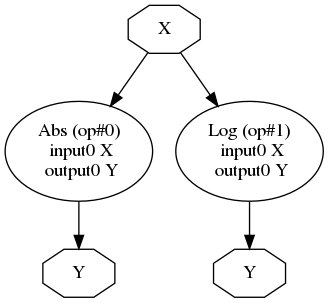

In [112]:
onnx_file = 'abs-log-ops.onnx'
with open(onnx_file, "wb") as f:
    f.write(two_node_model.SerializeToString())
graph_img = viz_model(onnx_file)
Image(graph_img)

## Test 2

In [116]:
node_abs_2 = helper.make_node(
    'Abs', # node name
    ['X'], # inputs
    ['Y'], # outputs
)

node_log_2 = helper.make_node(
    'Log', # node name
    ['Y'], # inputs
    ['Z'], # outputs
)

graph_def_2 = helper.make_graph(
    [node_abs, node_log],
    'abs_log',
    [X],
    [Z],
)

two_node_model_2 = helper.make_model(graph_def_2, producer_name='abs-log-ops')

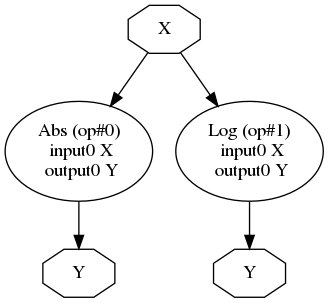

In [117]:
onnx_file_2 = 'abs-log-ops.onnx'
with open(onnx_file_2, "wb") as f:
    f.write(two_node_model_2.SerializeToString())
graph_img_2 = viz_model(onnx_file_2)
Image(graph_img_2)

---

# End of script